In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Stateful Nodes

In some cases, we would like our node to be stateful.
If you are not sure whether you should make your node stateful, you probably dont.

But you can, here is how:

In [ ]:
# you define a function object that has __call__ method
class StatefulSum():

    def __init__(self):
        self.history = []
    def __call__(self,item):
        self.history.append(item)
        return sum(self.history)
    def __str__(self):
        return f'StatefulSum'

    # And you have to implement the following 3 methods
    # reset the state
    def reset(self):
        self.history = []

    # dump the state as a json serializable object
    def dump_state(self):
        return self.history

    # load the state from a json serializable object
    def load_state(self,state_object):
        self.history = state_object


In [ ]:
s = StatefulSum()
s(1)
s(2)
s(3)
s.dump_state()

[1, 2, 3]

In [ ]:
from stringdale import V,E,Define,Condition
from pydantic import BaseModel,ConfigDict

In [ ]:
class TimerState(BaseModel):
    model_config = ConfigDict(extra='allow')
    timer: int = 0

    def set_timer(self,val):
        self.timer = val

    def tick(self):
        self.timer = self.timer -1 
        return self.timer

    @classmethod
    def is_time_up(cls,val):
        return val <= 0

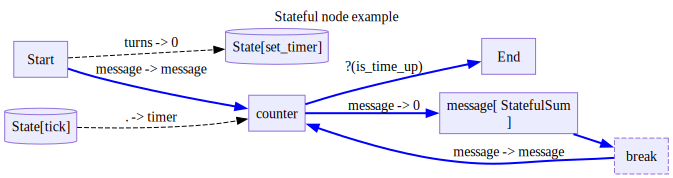

In [ ]:
with Define('Stateful node example',type='decision',state=TimerState()) as D:
    V('Start',outputs=[
        'state/set_timer(0=turns)',
        'counter(message=message)'
    ])

    V('counter',
        inputs=['state/tick(timer)'],
        outputs=[
            ('End',Condition(TimerState.is_time_up,'0=timer','is_time_up')),
            'message(0=message)'
        ]
        )

    V('message',StatefulSum(),outputs=['break']),
    V('break',is_break=True,outputs=['counter(message=message)'])

D.draw()

In [ ]:
inputs = [
    {'message':1,'turns':4},
    {'message':2},
    {'message':3},
    {'message':4},
]
d=D()

while True:
    inp = inputs.pop(0)
    for trace in d.run(inp):
        trace.pprint(skip_passthrough=True)
    
    print(d['message'])
    print(d['message'].history)

    if d.finished:
        break
    

inputs

Node message:
{'input': {0: 1}, 'output': 1}
StatefulSum
[1]
Node message:
{'input': {0: 2}, 'output': 3}
StatefulSum
[1, 2]
Node message:
{'input': {0: 3}, 'output': 6}
StatefulSum
[1, 2, 3]
StatefulSum
[1, 2, 3]


[]

We can see the message history by accessing the message node:

In [ ]:
d['message']

<__main__.StatefulSum>

In [ ]:
d['message'].history

[1, 2, 3]

## Example - simplifying react

A stateful node you have seen before is `Chat`. Chat has extra parameters that allows it to save its own history and initialize it with some prompt.
For a full understanding of Chat's parameters, see the reference section.

Let us see how we can use the stateful-ness of chat to simplify our react agent shown in the customizing state tutorial.

In [ ]:
from stringdale.chat import Chat
from stringdale.tools import wikipedia_search,run_python_code
from typing import Literal,Optional

In [ ]:
react_system_prompt = [{'role':'system','content':"""
Answer the following questions as best you can.
Here is an example of the format of the answer:
Question: the input question you must answer
Thought: you should always think about what to do
Tool Name: the name of the tool you will use
Tool Input: the input to the tool
Observation: the result of the tool
This thought - tool name - tool input - observation can repeat N times
Final Answer: the final answer to the original input question
Each time you are prompter either provide a thought that you need to use a tool or provide a final answer.
the tool name, input and observation will be provided to you in the next message.

Example:
user:
Question: what is the year five years from now?
assistant:
Thought: I need to compute the current year
Tool Name: wikipedia_search
Tool Input: {query: 'what is the current year'}
Observation: 2024
Thought: I need to add 5 to the current year
Tool Name: run_python_code
Tool Input: {code: 'import datetime; result = datetime.datetime.now().year + 5',output_expression='result'}
Observation: 2029
Final Answer: 2029
"""}]


class Thought(BaseModel):
    type: Literal['thought','final_answer']
    text: str

react_cot_chat = Chat(model='gpt-4o-mini',
    save_history=True,
    init_messages=react_system_prompt,
    output_schema=Thought,
    )
react_cot_chat

Chat(model='gpt-4o-mini', output_schema=Thought, seed=42, save_history=True)

In [ ]:
tools = {
    'wikipedia_search':wikipedia_search,
    'run_python_code':run_python_code,
}


react_tool_step = Chat(model='gpt-4o-mini',
    messages= [
        {'role':'system','content':'choose an appropriate tool to use to answer the following:'},
        {'role':'user','content':'{{thought}}'}],
    tools=tools,
    call_function=True
    )


In [ ]:
def react_cot_format(tool_name,input,output):
    return [{
        'role':'assistant',
        'content':f"""Tool Name: {tool_name}
Tool Input: {input}
Observation: {output}"""
    }]

is_final_answer= Condition('final_answer','(0=content.type)',name='is_final_answer')

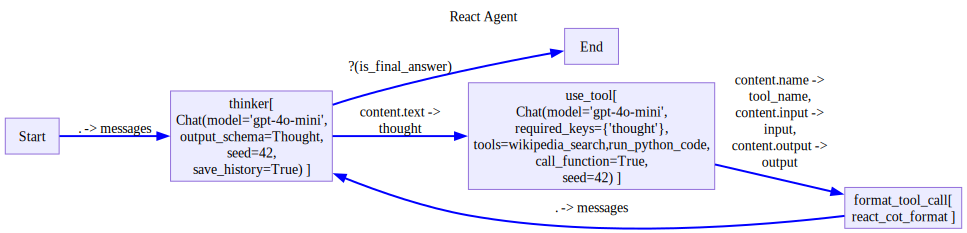

In [ ]:
with Define('React Agent',type='decision') as ReactAgent:

    V('thinker',react_cot_chat,
        inputs = ['Start(messages)'],
        outputs = [
            ('End',is_final_answer),
            'use_tool(thought=content.text)'])
    V('use_tool',react_tool_step,outputs=['format_tool_call(tool_name=content.name,input=content.input,output=content.output)'])
    V('format_tool_call',react_cot_format,
        outputs =[
            'thinker(messages)'
        ])
ReactAgent.draw()

In [ ]:
d=ReactAgent()
for trace in d.run([{'role':'user','content':"Question: what is obamas age to the power of 2?"}]):
    pass
d.output


{'role': 'assistant',
 'content': Thought(type='final_answer', text="Barack Obama's age squared is 3969."),
 'meta': {'input_tokens': 18271, 'output_tokens': 25}}

We can access the Chat's history using the histroy attribute as well,
though this is used for debugging. To access the history of a diagram in production, either:

* save it in a state that you return to the end node.
* save the relevant traces when running the diagram.

In [ ]:
d['thinker'].history

[{'role': 'system',
  'content': 'Answer the following questions as best you can.\nHere is an example of the format of the answer:\nQuestion: the input question you must answer\nThought: you should always think about what to do\nTool Name: the name of the tool you will use\nTool Input: the input to the tool\nObservation: the result of the tool\nThis thought - tool name - tool input - observation can repeat N times\nFinal Answer: the final answer to the original input question\nEach time you are prompter either provide a thought that you need to use a tool or provide a final answer.\nthe tool name, input and observation will be provided to you in the next message.\n\nExample:\nuser:\nQuestion: what is the year five years from now?\nassistant:\nThought: I need to compute the current year\nTool Name: wikipedia_search\nTool Input: {query: \'what is the current year\'}\nObservation: 2024\nThought: I need to add 5 to the current year\nTool Name: run_python_code\nTool Input: {code: \'import d